In [155]:
# Cell 1: Install & imports
# !pip install gymnasium stable-baselines3[extra] pandas numpy matplotlib ta tqdm joblib scipy

import os
import glob
import json
import math
import random
from typing import Callable, List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.utils import set_random_seed

os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [156]:
# Cell 2: List files available in ./data/
dataset_dir = "data/*.pkl"
files = sorted(glob.glob(dataset_dir))
print(f"Found {len(files)} datasets:")
for f in files:
    print(" -", f)


Found 9 datasets:
 - data/binance-BTCUSD-1h.pkl
 - data/binance-DOGEEUR-1h.pkl
 - data/binance-ETHUSD-1h.pkl
 - data/yfinance-AAPL-1h.pkl
 - data/yfinance-CAC40-1h.pkl
 - data/yfinance-EURUSD-1h.pkl
 - data/yfinance-GOLDUSD-1h.pkl
 - data/yfinance-S&P500-1h.pkl
 - data/yfinance-STOXX50-1h.pkl


In [157]:
# Cell 3: Loader utility
def load_pkl(path: str) -> pd.DataFrame:
    df = pd.read_pickle(path)
    if not isinstance(df.index, pd.DatetimeIndex):
        for col in ["datetime", "date", "time", "timestamp", "Timestamp"]:
            if col in df.columns:
                df = df.set_index(pd.to_datetime(df[col]))
                break
    df.index = pd.to_datetime(df.index)
    return df

# Quick check
if files:
    sample_df = load_pkl(files[0])
    print(sample_df.head(3))

Exception ignored in: <_io.FileIO name='/Users/gueguenoucedric/Documents/RL-projet-trading/models/ppo_trading/monitor.csv' mode='wb' closefd=True>
Traceback (most recent call last):
  File "/Users/gueguenoucedric/Documents/RL-projet-trading/.venv/lib/python3.13/site-packages/pandas/core/arrays/datetimes.py", line 668, in __iter__
    converted = ints_to_pydatetime(


                        open     high      low    close      volume  \
date_open                                                             
2020-08-11 07:00:00  11785.0  11785.0  11735.0  11751.4    7.560836   
2020-08-11 08:00:00  11752.2  11780.2  11711.9  11717.7  191.028616   
2020-08-11 09:00:00  11718.9  11772.3  11704.2  11716.2  189.694611   

                             date_close  
date_open                                
2020-08-11 07:00:00 2020-08-11 08:00:00  
2020-08-11 08:00:00 2020-08-11 09:00:00  
2020-08-11 09:00:00 2020-08-11 10:00:00  


In [158]:
# Cell 4: Preprocess & feature engineering
import pandas as pd
import numpy as np
from typing import Tuple

def feature_log_return(df: pd.DataFrame, col: str = "close") -> pd.Series:
    return np.log(df[col]).diff()

def feature_moving_average(df: pd.DataFrame, col: str = "close", window: int = 20) -> pd.Series:
    return df[col].rolling(window).mean()

def feature_volatility(df: pd.DataFrame, col: str = "close", window: int = 20) -> pd.Series:
    return df[col].pct_change().rolling(window).std()

def feature_RSI(df: pd.DataFrame, col: str = "close", window: int = 14) -> pd.Series:
    delta = df[col].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def feature_MACD(df: pd.DataFrame, col: str = "close", fast: int = 12, slow: int = 26, signal: int = 9) -> Tuple[pd.Series, pd.Series]:
    ema_fast = df[col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

def feature_OBV(df: pd.DataFrame, col_close: str = "close", col_volume: str = "volume") -> pd.Series:
    if col_volume not in df.columns:
        return pd.Series(0, index=df.index)
    obv = [0]
    for i in range(1, len(df)):
        if df[col_close].iat[i] > df[col_close].iat[i - 1]:
            obv.append(obv[-1] + df[col_volume].iat[i])
        elif df[col_close].iat[i] < df[col_close].iat[i - 1]:
            obv.append(obv[-1] - df[col_volume].iat[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df.index)

def zscore(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / (series.std() + 1e-9)

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.sort_index().drop_duplicates().dropna(how="all")
    if "close" not in df.columns:
        for c in ["Close", "Adj Close", "adjclose", "adj_close"]:
            if c in df.columns:
                df["close"] = df[c]
                break
    if "volume" not in df.columns:
        df["volume"] = 0

    # Features
    df["feature_log_return"] = feature_log_return(df, "close")
    df["feature_RSI"] = feature_RSI(df, "close")
    macd, macd_signal = feature_MACD(df, "close")
    df["feature_MACD"] = macd
    df["feature_MACD_signal"] = macd_signal
    for w in [5, 20, 50]:
        df[f"feature_ma_{w}"] = feature_moving_average(df, "close", w)
    for w in [10, 20, 50]:
        df[f"feature_vol_{w}"] = feature_volatility(df, "close", w)
    df["feature_OBV"] = feature_OBV(df, "close", "volume")

    # Fillna + zscore
    feat_cols = [c for c in df.columns if c.startswith("feature_")]
    for c in feat_cols:
        # CORRECTION : Remplacer df[c].fillna(method="ffill") par df[c].ffill()
        # Cela supprime le FutureWarning de Pandas
        df[c] = df[c].ffill().fillna(0) 
        df[c] = zscore(df[c])
    return df.dropna()

In [159]:
# def reward_function_log_return(history) -> float:
#     """
#     Fonction de récompense basée sur le rendement logarithmique du portefeuille.
#     Utilise len(history) au lieu de history.shape[1] pour vérifier la taille.
#     """
  
#     current_value = history['portfolio_valuation', -1]
    
   
#     if len(history) < 2:
#         return 0.0
        
#     previous_value = history['portfolio_valuation', -2]
    
#     if previous_value <= 0:
#         return 0.0

#     return np.log(current_value / previous_value)

# def metric_portfolio_valuation(history) -> float:
#     """
#     Métrique pour suivre la valeur du portefeuille.
#     """
#     # L'argument est aussi l'objet History ici.
#     return round(history['portfolio_valuation', -1], 2)


# # Définition de la fonction de récompense corrigée
# reward_function = reward_function_log_return

In [160]:
import numpy as np # Assurez-vous que numpy est bien importé

def reward_function_sharpe(history) -> float:
    """
    Fonction de récompense ajustée au risque, basée sur un Ratio de Sharpe instantané.
    Version corrigée pour robustesse des types et des valeurs.
    """
    current_value = history['portfolio_valuation', -1]
    
    # 1. Calcul du Rendement Instantané (Log Return)
    if len(history) < 2:
        return 0.0
        
    previous_value = history['portfolio_valuation', -2]
    
    # Gestion des valeurs non valides
    if previous_value <= 0 or current_value <= 0:
        return -1.0 

    instant_log_return = np.log(current_value / previous_value)
    
    # 2. Calcul de la Volatilité Historique
    WINDOW = 50 
    
    # Récupérer les valeurs historiques et forcer la conversion en array de flottants
    all_values_raw = history['portfolio_valuation']
    
    # *** CORRECTION MAJEURE: Forcer un type et filtrer les zéros/négatifs ***
    # 1. Conversion en tableau NumPy de type float
    all_values_np = np.asarray(all_values_raw, dtype=np.float64)
    
    # 2. Filtrer les valeurs non positives (où log n'est pas défini)
    # Remplacer les valeurs non positives par une petite valeur positive (1e-9) pour éviter l'erreur.
    safe_values = np.where(all_values_np <= 0, 1e-9, all_values_np) 

    if len(safe_values) > 1:
        # np.log applique le logarithme à chaque élément du tableau
        log_returns = np.diff(np.log(safe_values))
    else:
        log_returns = np.array([0.0])

    # Calculer la volatilité glissante sur la fenêtre
    if len(log_returns) >= WINDOW:
        volatility = np.std(log_returns[-WINDOW:]) 
    else:
        volatility = np.std(log_returns) if len(log_returns) > 1 else 1e-9

    volatility = max(volatility, 1e-9)
    
    # 3. Récompense ajustée au risque
    return instant_log_return / volatility * 0.1

In [161]:
reward_function = reward_function_sharpe

In [162]:
env = gym.make(
    "MultiDatasetTradingEnv",
    dataset_dir="data/*.pkl",
    preprocess=preprocess,
    portfolio_initial_value=1_000,
    trading_fees=0.1/100,
    borrow_interest_rate=0.02/100/24,
    reward_function=reward_function,
)

In [163]:
def metric_portfolio_valuation(history):
    return round(history['portfolio_valuation', -1], 2)

env.add_metric('Portfolio Valuation', metric_portfolio_valuation)

done = False
obs, _ = env.reset()

while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

Market Return : 103.26%   |   Portfolio Return : -100.00%   |   Portfolio Valuation : 0.02   |   


In [164]:
# Cell 7: Configuration de l'Environnement pour SB3 et Normalisation (Corrigée)

# S'assurer que les métriques sont ajoutées pour le suivi durant l'entraînement
def metric_portfolio_valuation(history) -> float:
    return round(history['portfolio_valuation', -1], 2)
# NOTE : La ligne suivante doit être exécutée UNIQUEMENT sur l'environnement non wrappé initial.
# Assurez-vous d'exécuter cette ligne avant Monitor(env).

# --- NOUVEAU : Définir le chemin de log ici, même si l'initialisation du modèle est après ---
# On utilise ici un chemin générique qui sera le dossier parent du monitor.csv
MONITOR_LOG_DIR = "models/ppo_trading" 
os.makedirs(MONITOR_LOG_DIR, exist_ok=True)


# 1. Envelopper l'environnement avec Monitor (pour le suivi des récompenses)
# IMPORTANT : Spécifier le chemin du fichier log ici
env = Monitor(env, filename=os.path.join(MONITOR_LOG_DIR, "monitor.csv")) 
# NOTE : Si env.add_metric('Portfolio Valuation', metric_portfolio_valuation) a été exécuté
# après la première initialisation de 'env', cela ne fonctionnera pas sur le Monitor.
# Vérifiez que 'env' n'est pas un Monitor avant d'ajouter les métriques.


# 2. Créer un environnement vectorisé
vec_env = DummyVecEnv([lambda: env])

# 3. Normalisation des Observations
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.)

print("Environnement configuré pour l'entraînement avec Normalisation.")

Environnement configuré pour l'entraînement avec Normalisation.


In [165]:
# # Cell 8: Entraînement de l'Agent SAC

# # Définir le chemin pour sauvegarder le meilleur modèle
# log_dir = "models/sac_trading"
# os.makedirs(log_dir, exist_ok=True)

# # Callback pour sauvegarder le modèle à intervalles réguliers (ex: tous les 10000 steps)
# checkpoint_callback = CheckpointCallback(
#     save_freq=10000, 
#     save_path=log_dir, 
#     name_prefix="sac_model"
# )

# # 1. Initialisation du Modèle SAC
# # policy="MlpPolicy" (Multi-Layer Perceptron pour les environnements continus)
# # gamma=0.99 (facteur de réduction des récompenses futures)
# # learning_rate=3e-4 (taux d'apprentissage standard)
# model = SAC(
#     "MlpPolicy", 
#     vec_env, 
#     verbose=1, 
#     # Paramètres d'hyperapprentissage typiques
#     gamma=0.99, 
#     learning_rate=3e-4,
#     # Utilisation d'un seed pour la reproductibilité
#     seed=set_random_seed(42),
# )

# # 2. Lancement de l'Entraînement
# TIMESTEPS = 500000 # Un minimum pour commencer. Vous aurez besoin de 500k+ pour de bons résultats.
# print(f"Début de l'entraînement pour {TIMESTEPS} timesteps...")

# model.learn(
#     total_timesteps=TIMESTEPS, 
#     callback=checkpoint_callback
# )

# print("\nEntraînement terminé. Modèle sauvegardé.")

# # Sauvegarder l'environnement normalisé (crucial pour le chargement futur)
# vec_env.save(os.path.join(log_dir, "vec_normalize.pkl"))
# model.save(os.path.join(log_dir, "final_sac_model.zip"))

In [167]:
# Cell 8: Entraînement de l'Agent PPO (Test de Vitesse)

# NOTE : PPO nécessite des hyperparamètres spécifiques, en particulier n_steps et batch_size.
from stable_baselines3 import PPO # S'assurer d'importer PPO

# Définir le chemin pour sauvegarder le meilleur modèle
log_dir = "models/ppo_trading" # Changement du répertoire de log
os.makedirs(log_dir, exist_ok=True)

# Callback pour sauvegarder le modèle à intervalles réguliers
checkpoint_callback = CheckpointCallback(
    save_freq=10000, 
    save_path=log_dir, 
    name_prefix="ppo_model"
)

# 1. Initialisation du Modèle PPO
model = PPO(
    "MlpPolicy", 
    vec_env, 
    verbose=1, 
    # Paramètres d'hyperapprentissage PPO optimisés pour les VecEnv
    n_steps=2048, # Nombre d'étapes de collecte de données (laisser par défaut)
    batch_size=64, # Taille des lots de mise à jour (laisser par défaut)
    gamma=0.99, 
    learning_rate=1e-4,
    seed=set_random_seed(42),
    n_epochs=10,
)

# 2. Lancement de l'Entraînement
TIMESTEPS = 500000 # On garde 500k pour la comparaison
print(f"Début de l'entraînement PPO pour {TIMESTEPS} timesteps...")

# PPO met à jour le modèle sur 4 époques après chaque collecte (n_steps)
model.learn(
    total_timesteps=TIMESTEPS, 
    callback=checkpoint_callback
)

print("\nEntraînement PPO terminé. Modèle sauvegardé.")

# Sauvegarder l'environnement normalisé (crucial pour le chargement futur)
vec_env.save(os.path.join(log_dir, "vec_normalize.pkl"))
model.save(os.path.join(log_dir, "final_ppo_model.zip"))

Using cpu device
Début de l'entraînement PPO pour 500000 timesteps...
-----------------------------
| time/              |      |
|    fps             | 1815 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1479        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008077003 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -5.96e-06   |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0361      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00931    |
|    std                  | 0.985       |
|    v

In [169]:
# Cell 9: Évaluation de l'Agent Entraîné (Version Finale de la Récupération)

# 1. Réinitialiser l'environnement vectorisé pour un nouvel épisode
obs = vec_env.reset() 

done = False
print("\n--- Début de l'Évaluation de l'Agent PPO Entraîné ---")

final_info = None

while not done:
    action, _ = model.predict(obs, deterministic=True) 
    obs, reward, done_ancien, info = vec_env.step(action)
    
    if done_ancien[0]:
       
        final_info = info[0]
        done = True 


if final_info and 'episode' in final_info:
    
    base_env_unwrapped = vec_env.venv.envs[0].unwrapped
    base_env_unwrapped.close() # L'appel close() est souvent implémenté pour vider les buffers.

    try:
        final_metrics = base_env_unwrapped.get_metrics()
    except AttributeError:
       
        final_metrics = {'Erreur': "Impossible d'accéder aux métriques finales. La variable results_metrics n'a pas été mise à jour par l'environnement."}
        
    final_portfolio_value = final_metrics.get('Portfolio Valuation', 'N/A')

   

    print(f"Statut final: Épisode terminé.")
    print(f"Valeur finale du portefeuille après entraînement: ${final_portfolio_value}")
    print(f"Métriques finales: {final_metrics}")
else:
    print("Erreur : L'épisode ne s'est pas terminé correctement ou le dictionnaire 'info' n'a pas été capturé.")
    



--- Début de l'Évaluation de l'Agent PPO Entraîné ---
Market Return : 677.81%   |   Portfolio Return : 230.20%   |   Portfolio Valuation : 3301.98   |   
Statut final: Épisode terminé.
Valeur finale du portefeuille après entraînement: $3301.98
Métriques finales: {'Market Return': '677.81%', 'Portfolio Return': '230.20%', 'Portfolio Valuation': np.float64(3301.98)}


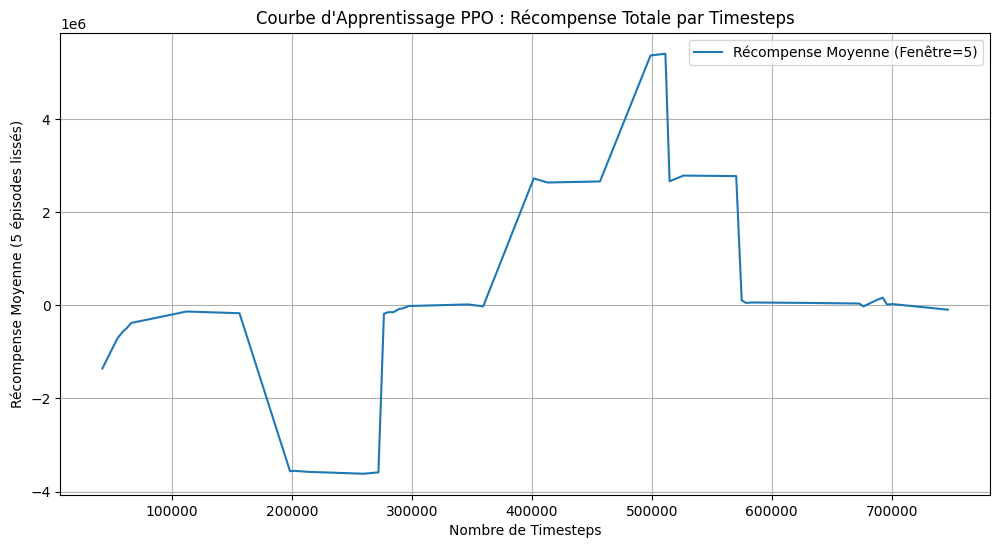


--- Diagnostic de Convergence ---
Nombre total d'épisodes terminés : 40
Récompense moyenne finale lissée : -92955.6423

NOTE : Trop peu d'épisodes pour un diagnostic fiable. Relancez l'entraînement sur 500k timesteps ou plus.


In [170]:
# Cell 11: Visualisation de la Courbe d'Apprentissage (Monitor)

from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Le fichier monitor.csv se trouve dans le répertoire des logs de l'Agent PPO
log_dir = "models/ppo_trading" 
monitor_path = os.path.join(log_dir, "monitor.csv")

if os.path.exists(monitor_path):
    try:
        # Charger les résultats
        df = load_results(log_dir)
    except pd.errors.EmptyDataError:
        print(f"Erreur: Le fichier {monitor_path} est vide ou mal formaté.")
        # Afficher le contenu pour inspection (dans un environnement de notebook)
        # with open(monitor_path, 'r') as f:
        #     print("Contenu du fichier monitor.csv:\n", f.read())
        # return # Sortir de la fonction si le fichier est vide
        
    
    # 1. Extraire les données (timesteps et récompenses)
    x, y = ts2xy(df, 'timesteps')
    
    # Déterminer la taille de la fenêtre de lissage
    num_episodes = len(y)
    
    # CORRECTION CRITIQUE : Ajuster la fenêtre de lissage
    if num_episodes > 100:
        window_size = 50
    elif num_episodes >= 5:
        # Utiliser un maximum de 10% des épisodes, minimum 5
        window_size = max(5, int(num_episodes * 0.1)) 
    else:
        # Si moins de 5 épisodes, ne pas lisser (fenêtre = 1)
        window_size = 1 

    # 2. Lissage (Rolling Mean) pour une meilleure lisibilité
    if window_size > 1:
        y_smoothed = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
    else:
        y_smoothed = pd.Series(y) # Données brutes si pas assez d'épisodes
        
    # 3. Affichage
    plt.figure(figsize=(12, 6))
    plt.plot(x, y_smoothed, label=f'Récompense Moyenne (Fenêtre={window_size})')
    plt.title("Courbe d'Apprentissage PPO : Récompense Totale par Timesteps")
    plt.xlabel("Nombre de Timesteps")
    plt.ylabel(f"Récompense Moyenne ({window_size} épisodes lissés)")
    plt.grid(True)
    plt.legend()
    plt.show() # Affiche le graphique

    # --- Interprétation ---
    last_reward = y_smoothed.iloc[-1]
    
    print("\n--- Diagnostic de Convergence ---")
    print(f"Nombre total d'épisodes terminés : {num_episodes}")
    print(f"Récompense moyenne finale lissée : {last_reward:.4f}")
    
    if num_episodes < 50:
        print("\nNOTE : Trop peu d'épisodes pour un diagnostic fiable. Relancez l'entraînement sur 500k timesteps ou plus.")
    elif last_reward > y_smoothed.iloc[window_size]:
        print("\n La récompense est en amélioration par rapport au début.")
    else:
        print("\n La récompense stagne ou a chuté. L'entraînement pourrait être inefficace ou nécessiter plus de temps.")
    
    
else:
    print(f"Erreur: Fichier {monitor_path} non trouvé. Assurez-vous d'avoir relancé l'entraînement après la correction de la Cellule 7.")